In [2]:
import matplotlib.pyplot as plt

In [19]:
def plot_result(bb_result, pb_result, title):
    x_bb, y_bb = zip(*bb_result)
    x_pb, y_pb = zip(*pb_result)

    plt.figure(figsize=(10, 6))
    
    plt.plot(x_bb, y_bb, label='Bit-Blasting', marker='o', color='b')
    plt.plot(x_pb, y_pb, label='PB-Blasing', marker='s', color='r')
    
    plt.xlabel('Bits')
    plt.ylabel('Milliseconds')
    plt.title(title)
    
    plt.legend()
    
    plt.grid(True)
    plt.show()

## Problem: Yoni
$$
a \cdot b \neq (a\ \& \sim b) \cdot (\sim a\ \&\ b) + (a\ \&\ b) \cdot (a\ |\ b)
$$
```
(set-logic QF_BV)
(declare-const a (_ BitVec SIZE))
(declare-const b (_ BitVec SIZE))
(assert
  (distinct
    (bvmul a b)
    (bvadd
      (bvmul (bvand a (bvnot b)) (bvand (bvnot a) b))
      (bvmul (bvand a b) (bvor a b)))
  )
)
(check-sat)
```

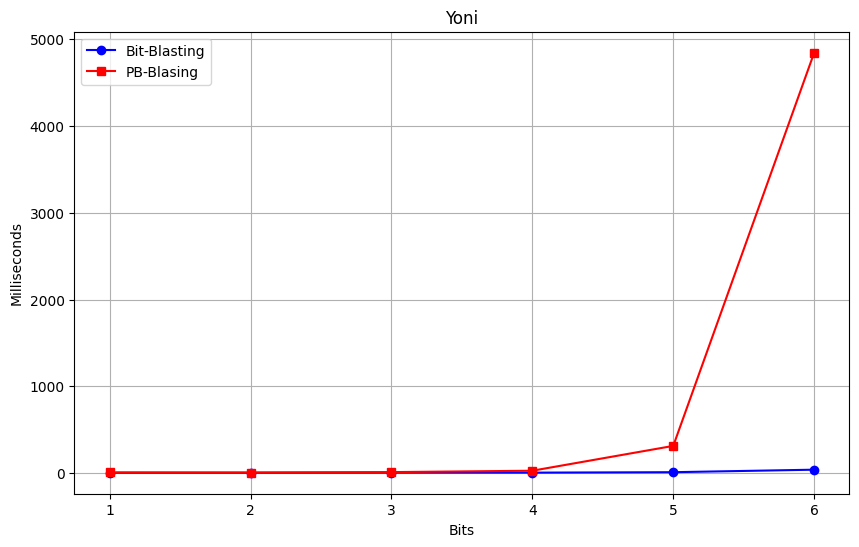

In [20]:
bb_result = [(1, 5), (2, 5), (3, 6), (4, 6), (5, 11), (6, 40),]
pb_result = [(1, 8), (2, 7), (3, 12), (4, 28), (5, 314), (6, 4844),]
plot_result(bb_result, pb_result, "Yoni")